<a href="https://colab.research.google.com/github/Theanh130124/SIC_Plagiarism_Detector/blob/random_forest/Plagiarism_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [1]:
!pip install contractions
!pip install gensim


In [2]:
import re
import pandas as pd
import numpy as np
import nltk
import spacy
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import contractions # can't -> cannot
import kagglehub
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

#Load Dataset

In [3]:
path = kagglehub.dataset_download("ruvelpereira/mit-plagairism-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mit-plagairism-detection-dataset


In [4]:
file_path = os.path.join(path, "train_snli.txt")
with open(file_path, encoding='utf-8') as file:
    data = file.readlines()


with open('data.csv', 'w', newline= '') as csvfile:
  filenames = ['source_txt', 'plagiarism_txt', 'label']
  writer = csv.DictWriter(csvfile, fieldnames=filenames)
  writer.writeheader()
  for line in tqdm(data):
    parts = line.strip().split('\t')
    source_txt = parts[0]
    plagiarism_txt = parts[1]
    label = parts[2]
    writer.writerow({'source_txt': source_txt, 'plagiarism_txt': plagiarism_txt, 'label': label})
print('CSV file created successfully...')


  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


#Check Sample

In [5]:
df = pd.read_csv('/content/data.csv')
df.sample(5) #random

,source_txt,plagiarism_txt,label
202898,A young woman wearing a black shirt is laying ...,The backpack serves as a pillow for the woman ...,1
33055,A woman in a red dress plays an unorthodox cello.,Two men shaking hands.,0
227278,A woman and a young man are enjoying each othe...,The store is exploding.,0
141781,"An older man, with a dirty white tank top, eat...",A young child sits inside the house.,0
190204,A girl is playing in a house between a window ...,There is a girl playing inside a house.,1


#Shape of Data

In [6]:
df.shape

(367373, 3)

#Check Mising Values

In [7]:
print("Null values",df.isnull().sum())
#remove null
df.dropna(inplace=True)
# check for null values after removing
print("==============================")
print("Null values after removing :",df.isnull().sum())

Null values source_txt        0
plagiarism_txt    4
label             0
dtype: int64
Null values after removing : source_txt        0
plagiarism_txt    0
label             0
dtype: int64


#Check Duplicate

In [8]:
print("Duplicates",df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)
# check for duplicates after removing
print("==============================")
print("Duplicates after removing :",df.duplicated().sum())

Duplicates 454
Duplicates after removing : 0


#Check Values Count

label
0    183874
1    183041
Name: count, dtype: int64


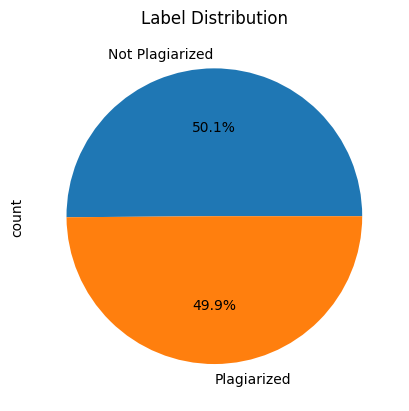

In [9]:
# check value counts  -> Ktra dataset cân bằng
print(df['label'].value_counts())

# Pie Chart
df['label'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Not Plagiarized', 'Plagiarized'])
plt.title('Label Distribution')
plt.show()



#Check Text Length

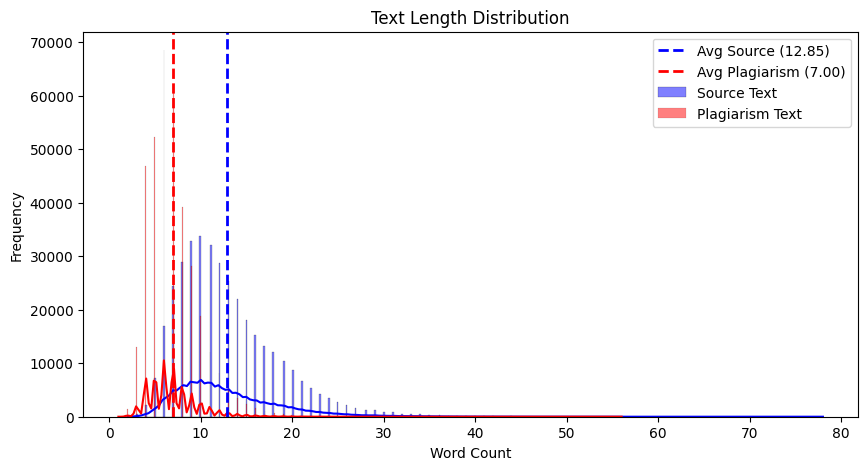

In [11]:
df['source_len'] = df['source_txt'].apply(lambda x:len(x.split()))
df['plagiarism_len'] = df['plagiarism_txt'].apply(lambda x:len(x.split())) #Cắt ra khoảng trắng và đếm


#Vẽ biểu đồ tần suất phân bố dữ liệu (Plot histograms)
plt.figure(figsize=(10,5)) #1 ô có kích thước
sns.histplot(df['source_len'], color='blue' , label='Source Text' , kde=True) #KDE đường cong mật độ
sns.histplot(df['plagiarism_len'] , color='red' , label = 'Plagiarism Text', kde =True)


#Tính mean
avg_source_len = df['source_len'].mean()
avg_plagiarism_len = df['plagiarism_len'].mean()


#Thêm avg và plot
plt.axvline(avg_source_len, color='blue', linestyle='dashed', linewidth=2, label=f'Avg Source ({avg_source_len:.2f})')
plt.axvline(avg_plagiarism_len, color='red', linestyle='dashed', linewidth=2, label=f'Avg Plagiarism ({avg_plagiarism_len:.2f})')


plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend() #plot note
plt.show()


#Kết luận


- Biểu đồ phân bố độ dài văn bản cho thấy sự khác biệt rõ rệt giữa văn bản gốc (source texts) và văn bản đạo văn (plagiarized texts):

+ Văn bản gốc (Source texts) có độ dài trung bình khoảng 12.85 từ và có phân bố rộng hơn(kde rộng hơn từ 0 - gần 80), trải dài từ những đoạn ngắn đến các đoạn dài hơn. Điều này phản ánh sự đa dạng về nội dung và ngữ cảnh của các văn bản gốc.

+ Văn bản đạo văn (Plagiarized texts) có độ dài trung bình thấp hơn, chỉ khoảng 7.00 từ, và tập trung chủ yếu ở các đoạn văn ngắn. Phân bố của chúng hẹp hơn(kde từ 0 đến gần 60) và phần lớn tập trung vào khoảng độ dài ngắn.

Ý nghĩa:
Điều này cho thấy hành vi đạo văn trong bộ dữ liệu chủ yếu diễn ra trên các đoạn văn ngắn, thay vì sao chép toàn bộ hoặc những đoạn dài. Người thực hiện hành vi đạo văn có xu hướng lấy các phần nhỏ của văn bản gốc để tái sử dụng



#WordCloud

(-0.5, 799.5, 399.5, -0.5)

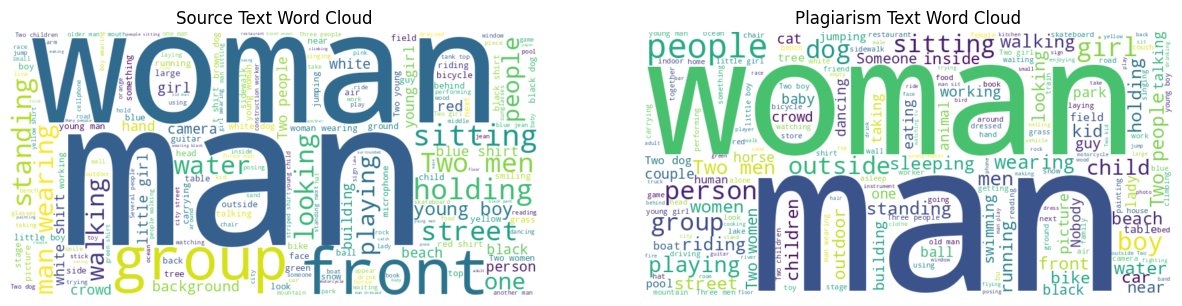

In [12]:
#Tạo wordcloud -> từ càng xh nhiều càng to

source_text = " ".join(df['source_txt'].tolist())
wordcloud_source = WordCloud(width=800, height=400, background_color='white').generate(source_text)

plag_text = " ".join(df['plagiarism_txt'].tolist())
wordcloud_plag = WordCloud(width=800, height=400, background_color='white').generate(plag_text)


#Hiển thị word Cloud
plt.figure(figsize=(15, 7))

# Source Text Word Cloud
plt.subplot(1, 2, 1) #1 hàng 2 cột , và nó là cột 1
plt.imshow(wordcloud_source, interpolation='bilinear') #làm mượt khi thu phóng
plt.title('Source Text Word Cloud')
plt.axis('off')#tắt xy


# Plagiarism Text Word Cloud
plt.subplot(1, 2, 2)#1 hàng 2 cột , và nó là cột 2
plt.imshow(wordcloud_plag, interpolation='bilinear')
plt.title('Plagiarism Text Word Cloud')
plt.axis('off')

Data Preprocessing (Tiền xử lý dữ liệu)

In [13]:
#NLTK Downloads

nltk.download('stopwords')


#Load SpaCy

nlp = spacy.load('en_core_web_sm')  #Có thể Part of speech tagging vầ NER (nhận diện thực thể qua tên)


def to_lowercase(text):
    return text.lower()

#Xóa dấu câu
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text) #sub như substitute (thay thế) thay '' cho những dấu câu
#Xóa kí tự đặc biệt và số

def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', '', text)


#Xóa HTML tags
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

#Xóa emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Xóa urls

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#Xóa khoảng trắng thừa
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

#Từ can't -> can not
def expand_contractions(text):
    return contractions.fix(text)

#Xóa stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text.split()
    return " ".join([word for word in tokens if word not in stop_words])

#Tokenization and Lemmatization (tách từ và tìm từ gốc) I'm running -> "I" , "am" "run"
def spacy_tokenization_lemmatization(text):
    doc= nlp(text) #spaCy
    return [token.lemma_ for token in doc]

#Xóa 1 từ cụ thể nếu muốn

def remove_specific_words(text,words_to_remove):
    words = text.split()
    filtered_words = [word for word in words if word not in words_to_remove]
    return " ".join(filtered_words)

#
def full_pipeline(text):
    text = to_lowercase(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_html_tags(text)
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords(text)
    tokens = spacy_tokenization_lemmatization(text)
    text = " ".join(tokens)
    text = remove_specific_words(text, ['chat'])  # Remove 'chat' specifically
    return text






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#vectorized data(word2vec)

In [14]:
%%time


from gensim.models import Word2Vec
import numpy as np

# ========== Tách 1 câu thành từ từ cho Word2Vec ==========
def tokenize(text):
    return text.split()

# ========== một câu là 1 mảng các từ đã tách ==========
source_sentences = df['processed_source_txt'].apply(tokenize).tolist()
plagiarism_sentences = df['processed_plagiarism_txt'].apply(tokenize).tolist()

# Kết hợp  cả 2 để có ngữ cảnh tốt hơn
all_sentences = source_sentences + plagiarism_sentences

# ========== Train Word2Vec Model ==========
w2v_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)



#Chuyển câu thành vector (word2vec chỉ học vector của từng từ nên cần )
# mảng câu đã được tách từ sentence  // lấy vector của từng từ model.wv[word] trong sentence
def sentence_to_vec(sentence , model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0) #tính mean tìm vector đại diện cho 1 từ -  theo cột (vì mỗi một cột là một chiều của 1 từ)
    else:
        return np.zeros(model.vector_size)



#Chuyển đổi văn bản đã xử lý thành vector số
df['source_vec'] = df['processed_source_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))
df['plagiarism_vec'] = df['processed_plagiarism_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))


print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'source_vec', 'processed_plagiarism_txt', 'plagiarism_vec']])



KeyError: 'processed_source_txt'